# CMSC320 Final Tutorial: poopy professors paid plenty
### Amelia Hsu, Jason Liu, and Brian Xiang

## Table of Contents
1. [Motivation](#introduction)
2. [Hypothesis](#hypothesis)
3. [Data Collection/Curation](#data-collectioncuration)
    1. [Diamondback Salary Guide](#diamondback-salary-guide)
    2. [Rate My Professors](#rate-my-professors)
    3. [PlanetTerp](#planetterp)
4. [Data Munging](#data-munging)
    1. [Tidying the Data](#tidying-the-data)
        1. [Diamondback Salary Guide](#diamondback-salary-guide)
        2. [Rate My Professors](#rate-my-professors)
        3. [PlanetTerp](#planetterp)
    2. [Name Matching](#name-matching)
    3. [Creating Reviews Dataset](#creating-reviews-dataset)
5. [Data Representation](#data-representation)
6. [Exploratory Data Analyis](#exploratory-data-analysis)
    1. [Inital Graphing](#initial-graphing)
    2. [Graphing by Department](#graphing-by-department)
    3. [Changes Over Time](#changes-over-time)
7. [Sentiment Analysis](#sentiment-analysis)
    1. [Some Fun with Word Clouds](#some-fun-with-word-clouds)
8. Hypothesis Testing
9. Insights and Conclusion

## Motivation

Let's be honest, professors all vary in teaching style (and quality). Students tend to be extremely vocal about their opinions of professors. Everyone is looking out for one other. Friends want each other to get the best professors that they can and avoid those that they may not learn the best from. As a result, online platforms have been created to house student reviews of professors, the most commonly known website being [Rate My Professors](https://ratemyprofessors.com), which has data on over 1.3 million professors, 7,000 schools and 15 million ratings. Three student at the University of Maryland, College Park even took the initiative to create their own platform to gather specifically UMD professor ratings, [PlanetTerp](https://planetterp.com/), which includes over 11,000 professors and 16,000 reviews. PlanetTerp has the additional feature of including course grades for each UMD course; as of right now there are nearly 300,000 course grades stored on the site.

Starting in 2013, The Diamondback, UMD's premier independent student newspaper, began publishing an annual salary guide: [The Diamondback Salary Guide](https://salaryguide.dbknews.com/). The Diamondback Salary Guide displays every university employee's yearly pay in an easily digestible format for all to view. This information is public data provided to The Diamondback by the university itself; The Diamondback simply made this data more accessible to all by posting it on a single website.

The Diamondback Salary Guide states, "[w]e won't tell you what conclusions to draw from these numbers, but it's our hope that they'll give you the information you need to reflect on your own." In this final tutorial, we plan to do just that: compare both the salaries and ratings of UMD professors and reflect on our findings. From our own past experiences, we have observed that our favorite professors are not always the ones being paid the highest salaries. We are interested in the possiblity of a potential correlation between these two attributes. If there is a correlation between professor salary and rating, what is it? If a correlation exists, can we use this information to predict professor salary based on student reviews and vice versa?

## Hypothesis

We hypothesize that there will be a correlation between a professor's salary and their rating, due to some departments who have tenured professors who have dropped their standard of teaching (to say the least).

## Data Collection/Curation

In order to observe the relationship between professor salary and rating, we collected data from three sources: Diamondback Salary Guide (DBK), Rate My Professors (RMP), and PlanetTerp (PT). DBK was our source of professor salary data, and a combination of RMP and PT was used as our source of professor rating data.

### Diamondback Salary Guide

Diamondback Salary Guide has an undocumented API. However, we were able to learn about the API by looking at the network requests as we modified parameters on the site, which meant we could programmatially go through all of the pages and pull full data for all of the years that the Salary Guide tracks (2013-2022).

Our scraping code for DBK data can be found in [`src/scrape_salaries.py`](./src/scrape_salaries.py)

<img src="src/img/dbk_request.png" width="1000"/>

### Rate My Professors

Rate My Professors also has an undocumented API. This is discovered by inspecting the network requests as we loaded a page of professor reviews, noting that there was a GraphQL query, then inspecting and then copying over the GraphQL query, authentication, and the necessary variables we needed to emulate the request locally. 

Interestingly, although their API technically requires authentication, the request from the website leaks the necessary [Basic authentication](https://en.wikipedia.org/wiki/Basic_access_authentication) header, which is `test:test` encoded in base64.

Our scraping code for RMP data can be found in [`src/scrape_rmp.py`](./src/scrape_rmp.py)

<img src="src/img/rmp_graphql.png" width="1000"/>

### PlanetTerp

PlanetTerp was created by UMD students and thus the creators were generous enough to document an [API](https://planetterp.com/api/) to help fellow students use the data available on their website. 

Using their `/api/v1/professors/` endpoint, we were able to collect a list of all of the professors that PlanetTerp has data on that have taught at UMD (over 11,000!), and get a list of all of the courses they've taught, their average rating over all of their courses, and all of their reviews, each of which included the text content, rating, expected grade, and creation time.

Our scraping code for PlanetTerp data can be found in [`src/scrape_pt.py`](./src/scrape_pt.py)

<img src="src/img/pt_request.png" width="1000"/>

## Data Munging

First, let's import our scraped data. We saved data collected from each of our three sources in their own separate CSV files.

In [1]:
import pandas as pd
import numpy as np

salaries_df = pd.read_csv("./src/data/salaries.csv")
pt_df = pd.read_csv("./src/data/pt_ratings.csv")
rmp_df = pd.read_csv("./src/data/rmp_ratings.csv")

### Tidying the Data

Before we began doing anything with our data, we first needed to clean it up.

#### Diamondback Salary Guide
The DBK salary guide formats names differently from PlanetTerp and RMP, and contains escaped newlines returned from the API requests. As such, we decided to rearrange the first and last names in order to help our fuzzy search algorithm, and replaced newlines with spaces throughout the dataset. We also converted the salary strings to floats and extracted the school from the department strings.


In [2]:
# Rearrange first and last names to standardize name search in salaries
salaries_df["name"] = salaries_df["employee"].apply(
    lambda x: " ".join(x.split(", ")[::-1])
)

# Replace newlines with spaces
salaries_df["department"] = salaries_df["department"].str.replace("\n", " ").str.strip()
# Converse salaries to floats
salaries_df["salary"] = (
    salaries_df["salary"].replace("[\$,]", "", regex=True).astype(float)
)
# Extract school from department data
salaries_df["school"] = salaries_df["department"].str.split("-").str[0]

# TODO: Use division instead of department cause less unique values
salaries_df.loc[~salaries_df["department"].str.contains("-"), "school"] = np.nan

#### Rate My Professors

While collecting data from RMP, we noticed something odd about each professor’s Overall Quality score. The results we calculated when averaging a professor’s individual quality ratings were not equal to the professor's Overall Quality score. We are not sure what factors are taken into account by RMP when calculating overall quality. When students create new reviews on RMP, they are asked to score the professor’s helpfulness and clarity. We can see each review’s helpfulRating and clarityRating in the API data which we collected. However, the RMP website only displays a “Quality” score. In the vast majority of cases, we have found that the Quality score is calculated by averaging the Helpful and Clarity scores ((helpfulRating + clarityRating) / 2). However, after performing a few calculations by hand, we found that a professor’s Overall Quality is not a result of averaging each review’s Quality score.

Let’s take Clyde Kruskal as an example: at the time of our calculations, RMP gave Kruskal an Overall Quality score of 2.30. However, the average of each review’s Quality was 2.14, the average of each review’s helpfulRating was 2.11, and the average of each review’s clarityRating was 2.16, none of which are equal to 2.30. It is unclear what is causing this discrepancy. Is RMP factoring in the difficulty ratings of the professors? How recent each review is? Overall Quality score is a mystery black box number to us.

Since we do not know how RMP is calculating this score, we chose to average each review’s quality rating and use this value for the average rating, since we know exactly how this is calculated.

In [3]:
rmp_df = rmp_df[rmp_df["reviews"] != "[]"]

# Snippet from src/scrape_rmp.py
def calculate_ratings():
    df = pd.DataFrame(columns=["name", "rating", "courses", "reviews"])

    for i, name in enumerate(names):
        splitted = name.split(" ")
        if len(splitted) >= 3:
            name = splitted[0] + " " + splitted[-1]
        print(f"getting reviews for {name} {i}/{len(names)}")
        courses = set()
        ratings = rmp_get_ratings(name)
        reviews = []
        score = 0
        for rating in ratings:
            data = rating["node"]
            course = data["class"]
            courses.add(course)
            score += data["clarityRating"]
            score += data["helpfulRating"]

            reviews.append(
                {
                    "professor": name,
                    "course": course,
                    "review": data["comment"],
                    "rating": data["clarityRating"],
                    "expected_grade": data["grade"],
                    "created": data["date"],
                }
            )

        if len(ratings) != 0:
            score /= len(ratings) * 2
        else:
            score = 0

        df.loc[len(df)] = [name, score, list(courses), reviews]

#### PlanetTerp

PlanetTerp has many listings for professors that have zero ratings, which is not helpful in our data exploration. For this reason, we removed all professors from our PT dataset who had no reviews. We also noticed that it was possible for PT to have multiple listings for the same professor (see [Madeleine Goh](https://planetterp.com/professor/goh) and [Madeleine Goh](https://planetterp.com/professor/goh_madeleine)). For professors with multiple listings, we merged the listings and combined all of their reviews, recalculating their average rating.

In [4]:
from ast import literal_eval

# Drop professors without any reviews
pt_df = pt_df[pt_df["reviews"] != "[]"]

### Name Matching

To connect a professor’s salary to their ratings, we needed to find a way to match the names from each dataset to each other. This proved to be a bit more difficult than we expected, because professor names were not standardized between the three platforms. Sometimes professor names included middle names, sometimes they included a middle initial, and sometimes no middle name was provided at all. Occasionally, professor nicknames were listed instead of their full names. With over three thousand different professors, we could not possibly match professor names by hand. Thus we needed a method to find the best professor matches between the three datasets. We used fuzzy name matching to accomplish this task. Fuzzy matching (also known as approximate string matching) is an artificial intelligence and machine learning technology that helps identify two elements that are approximately similar but not exactly the same. 

We explored two different options for matching professor names from PlanetTerp to Diamondback Salary Guide. One option that we considered was using [Hello My Name Is (HMNI)](https://github.com/Christopher-Thornton/hmni), a form of fuzzy name matching using machine learning. However, we decided against using HMNI because it was two years outdated and did not work with our current version of python3. The next method that we tried was using [fuzzywuzzy](https://github.com/seatgeek/thefuzz)  or [fuzzyset](https://github.com/Glench/fuzzyset.js/), which also performs fuzzy name matching but use the Levenshtein distance to calculate similarities between names. Levenshtein distance is the number of deletions, insertions, or substitutions required to transform one string to another. We ultimately decided to use fuzzyset to match professor names from PT to DBK because fuzzyset had faster performance than fuzzywuzzy, and we were receiving more successful, correct matches than with HMNI.

However, name matching did not end there. As previously mentioned, some professors had middle names or middle initials while others did not. This heavily impacted the Levenshtein distance calculations being performed by fuzzyset. After running a preliminary round of name matching, we noticed that many professors in PT were not being matched to the correct listing in DBK because of the presence/absence of middle names; this was especially the case for those with long middle names. In order to resolve this issue, we ran two rounds of fuzzyset name matching. We only ran a second round of name matching with professors that did not get matched in the first round, this time removing all middle names. With this addition, we were able to match over 500 previously unmatched professors whose data would have been thrown away without this change (the number of matched professors increased from 2,036 to 2,561). Both rounds considered a name match to be a string match with an [acceptance value? Levenshtein distance? help] of 0.80 or higher. We played around with adjusting the BLANK that was required in order for the names to count as a match (we tried values ranging from BLANK to BLANK, but we ultimately ended up settling on 0.80 because BLANK. While this does not 100% guarantee that every pair of names that we match are the same person, this method of name matching was the best that we could do considering that we did not have a validation set to check the accuracy of our fuzzy matching results and there were simply too many professor names for our group to check over every pairing by hand.

In [5]:
try:
    from cfuzzyset import cFuzzySet as FuzzySet
except ImportError:
    from fuzzyset import FuzzySet


def get_fl(s: str):
    sl = s.split()
    return f"{sl[0]} {sl[-1]}"


def fuzzy_merge(
    d1: pd.DataFrame, d2: pd.DataFrame, fuzz_on="", alpha=0.75, beta=0.75, how="inner"
):
    d1_keys = d1[fuzz_on]
    d2_keys = d2[fuzz_on]
    fuzz_left = len(d2_keys.unique()) > len(d1_keys.unique())

    if fuzz_left:
        fuzz = FuzzySet(d2_keys.unique())
        fuzz_fl = FuzzySet(d2_keys.apply(get_fl).unique())
    else:
        fuzz = FuzzySet(d1_keys.unique())
        fuzz_fl = FuzzySet(d1_keys.apply(get_fl).unique())

    def fuzzy_match(row):
        key = row[fuzz_on]
        matches = fuzz.get(key)
        match_conf, match_name = matches[0]

        # print(f"{key} -> {matches}")

        if match_conf <= beta:
            matches = fuzz_fl.get(key)
            match_conf, match_name = matches[0]
            # print(f"{key} -> {matches}")

        return match_name if match_conf >= alpha else None

    if fuzz_left:
        d1["_fuzz"] = d1.apply(fuzzy_match, axis=1)
        return pd.merge(d1, d2, left_on="_fuzz", right_on=fuzz_on, how=how).rename(
            columns={"_fuzz": fuzz_on}
        )
    else:
        d2["_fuzz"] = d2.apply(fuzzy_match, axis=1)
        return pd.merge(d1, d2, left_on=fuzz_on, right_on="_fuzz", how=how).rename(
            columns={"_fuzz": fuzz_on}
        )

In [6]:
merge_pt = fuzzy_merge(pt_df, salaries_df, fuzz_on="name", how="inner")
merge_pt.head()

C:\Users\ameli\AppData\Local\Temp\ipykernel_6072\3232062601.py:28: DeprecationWarning: This function will be remove in v3.0.0. Use rapidfuzz.distance.Levenshtein.normalized_similarity instead.
  matches = fuzz.get(key)
C:\Users\ameli\AppData\Local\Temp\ipykernel_6072\3232062601.py:34: DeprecationWarning: This function will be remove in v3.0.0. Use rapidfuzz.distance.Levenshtein.normalized_similarity instead.
  matches = fuzz_fl.get(key)


courses  average_rating  \
0  ['ENME674', 'ENMA300', 'ENME684', 'ENME489Z', ...             5.0   
1  ['ENME674', 'ENMA300', 'ENME684', 'ENME489Z', ...             5.0   
2  ['ENME674', 'ENMA300', 'ENME684', 'ENME489Z', ...             5.0   
3  ['ENME674', 'ENMA300', 'ENME684', 'ENME489Z', ...             5.0   
4  ['ENME674', 'ENMA300', 'ENME684', 'ENME489Z', ...             5.0   

        type                                            reviews  \
0  professor  [{'professor': 'Abhijit Dasgupta', 'course': '...   
1  professor  [{'professor': 'Abhijit Dasgupta', 'course': '...   
2  professor  [{'professor': 'Abhijit Dasgupta', 'course': '...   
3  professor  [{'professor': 'Abhijit Dasgupta', 'course': '...   
4  professor  [{'professor': 'Abhijit Dasgupta', 'course': '...   

             name_x              slug              name  year  \
0  Abhijit Dasgupta  dasgupta_abhijit  Abhijit Dasgupta  2013   
1  Abhijit Dasgupta  dasgupta_abhijit  Abhijit Dasgupta  2014   
2  Abhijit Dasgupta  dasgupta_abhijit  Abhijit Dasgupta  2015   
3  Abhijit Dasgupta  dasgupta_abhijit  Abhijit Dasgupta  2016   
4  Abhijit Dasgupta  dasgupta_abhijit  Abhijit Dasgupta  2017   

            employee                   department  \
0  Dasgupta, Abhijit  ENGR-Mechanical Engineering   
1  Dasgupta, Abhijit  ENGR-Mechanical Engineering   
2  Dasgupta, Abhijit  ENGR-Mechanical Engineering   
3  Dasgupta, Abhijit  ENGR-Mechanical Engineering   
4  Dasgupta, Abhijit  ENGR-Mechanical Engineering   

                               division title     salary            name_y  \
0  A. James Clark School of Engineering  Prof  167138.22  Abhijit Dasgupta   
1  A. James Clark School of Engineering  Prof  183580.92  Abhijit Dasgupta   
2  A. James Clark School of Engineering  Prof  190895.40  Abhijit Dasgupta   
3  A. James Clark School of Engineering  Prof  190895.40  Abhijit Dasgupta   
4  A. James Clark School of Engineering  Prof  198038.26  Abhijit Dasgupta   

  school  
0   ENGR  
1   ENGR  
2   ENGR  
3   ENGR  
4   ENGR

Matching professor names between Rate My Professors and Diamondback Salary Guide was much easier. Rather than taking names from the professor rating website and trying to find a match in DBK like we did with PT, RMP performed a fuzzy matching for us through their searching method. We were essentially able to perform fuzzy name matching while collecting the RMP data. As we were gathering the data from RMP, we fed the RMP API each name in our DBK dataset. If RMP found a match for the name, it returned the appropriate professor rating information. This meant that each professor we had in our RMP dataset was automatically matched with a professor in our DBK dataset as we gathered the RMP professor data.

In [7]:
# TODO: Explain this fuzzy merge & split ^ explanation between data collection + this paragrpah

In [8]:
merge_rmp = fuzzy_merge(rmp_df, salaries_df, fuzz_on="name", how="inner")
merge_rmp.head()

C:\Users\ameli\AppData\Local\Temp\ipykernel_6072\3232062601.py:28: DeprecationWarning: This function will be remove in v3.0.0. Use rapidfuzz.distance.Levenshtein.normalized_similarity instead.
  matches = fuzz.get(key)
C:\Users\ameli\AppData\Local\Temp\ipykernel_6072\3232062601.py:34: DeprecationWarning: This function will be remove in v3.0.0. Use rapidfuzz.distance.Levenshtein.normalized_similarity instead.
  matches = fuzz_fl.get(key)


name_x    rating                   courses  \
0  Pamela Abshire  3.333333  ['ENEE419A', 'ENEE408D']   
1  Pamela Abshire  3.333333  ['ENEE419A', 'ENEE408D']   
2  Pamela Abshire  3.333333  ['ENEE419A', 'ENEE408D']   
3  Pamela Abshire  3.333333  ['ENEE419A', 'ENEE408D']   
4  Pamela Abshire  3.333333  ['ENEE419A', 'ENEE408D']   

                                             reviews               name  year  \
0  [{'professor': 'Pamela Abshire', 'course': 'EN...  Pamela A. Abshire  2013   
1  [{'professor': 'Pamela Abshire', 'course': 'EN...  Pamela A. Abshire  2013   
2  [{'professor': 'Pamela Abshire', 'course': 'EN...  Pamela A. Abshire  2013   
3  [{'professor': 'Pamela Abshire', 'course': 'EN...  Pamela A. Abshire  2014   
4  [{'professor': 'Pamela Abshire', 'course': 'EN...  Pamela A. Abshire  2014   

             employee                              department  \
0  Abshire, Pamela A.  ENGR-Electrical & Computer Engineering   
1  Abshire, Pamela A.     ENGR-Institute for Systems Research   
2  Abshire, Pamela A.                     UGST-Honors College   
3  Abshire, Pamela A.  ENGR-Electrical & Computer Engineering   
4  Abshire, Pamela A.     ENGR-Institute for Systems Research   

                               division       title    salary  \
0  A. James Clark School of Engineering  Assoc Prof  82872.96   
1  A. James Clark School of Engineering  Assoc Prof  55149.36   
2                 Undergraduate Studies    Lecturer   5000.00   
3  A. James Clark School of Engineering  Assoc Prof  82427.95   
4  A. James Clark School of Engineering  Assoc Prof  66496.05   

              name_y school  
0  Pamela A. Abshire   ENGR  
1  Pamela A. Abshire   ENGR  
2  Pamela A. Abshire   UGST  
3  Pamela A. Abshire   ENGR  
4  Pamela A. Abshire   ENGR

#### Creating Reviews Dataset

After this long process, we finally had as many professor salaries matched to their ratings as possible. Any unmatched professor data was discarded.

In [9]:
reviews_df = []

for name, rows in pd.concat([merge_pt, merge_rmp]).groupby("name"):
    # display(rows["reviews"].unique())
    for rs in map(literal_eval, rows["reviews"].unique()):
        for r in rs:
            reviews_df.append({**r, "professor": name})

reviews_df = pd.DataFrame(reviews_df)
reviews_df = reviews_df.drop(columns=["expected_grade"])
reviews_df = reviews_df.rename(columns={"professor": "name"})
reviews_df["created"] = pd.to_datetime(reviews_df["created"].str.replace("UTC", ""))
reviews_df["year"] = pd.DatetimeIndex(reviews_df["created"]).year
# NOTE: This is a placeholde for later num_reviews calculations -- it should be 1 for each row
reviews_df["num_reviews"] = 1

reviews_df.head()

name    course  \
0  A W. Kruglanski  PSYC489H   
1     A.U. Shankar   CMSC412   
2     A.U. Shankar   CMSC412   
3     A.U. Shankar   CMSC412   
4     A.U. Shankar   CMSC412   

                                              review  rating  \
0  DO NOT TAKE PSYC489H "Motivated Social Cogniti...       2   
1  Lectures are pretty dry and difficult to follo...       3   
2  Professor: He does have a stutter, but if you ...       3   
3  This is a horrible class. The projects are imp...       1   
4  I have a lot of respect for Dr. Shankar. He is...       5   

                    created  year  num_reviews  
0 2015-09-07 18:44:00+00:00  2015            1  
1 2013-01-02 21:32:00+00:00  2013            1  
2 2012-12-23 03:51:00+00:00  2012            1  
3 2012-10-29 00:54:00+00:00  2012            1  
4 2012-05-24 13:00:00+00:00  2012            1

## Data Representation

Talk about how everything's in one dataframe? How we store data in CSVs? idk bro

## Exploratory Data Analysis

### Initial Graphing

After matching DBK salaries to PT ratings, we created a preliminary graph to visualize the data that we had tirelessly toiled to collect, tidy, and match.

For this first graph, we plotted every professor who has at least one review in either Rate My Professors and PlanetTerp and at least one entry in the Diamondback Salary Guide. We plotted each professor using their average rating and their most recently posted salary.

In [10]:
import plotly.io as pio
import matplotlib.pyplot as plt

pd.options.plotting.backend = "plotly"
# pio.renderers.default = 'browser'
pio.templates.default = "plotly_dark"
plt.style.use("dark_background")

In [11]:
salaries_df = salaries_df.groupby(["name", "year"], as_index=False).agg(
    {
        "school": "first",
        "salary": "sum",
    }
)

In [12]:
merged_all_years_all_reviews = salaries_df.merge(reviews_df, on=["name", "year"], how="right")

In [13]:
merged_2022_all_reviews = (
    salaries_df.merge(reviews_df, on=["name", "year"], how="outer")
    .sort_values("year", ascending=False)
    .groupby("name", as_index=False)
    .agg(
        {
            "school": "first",
            "salary": "first",
            "name": "first",
            "year": "first",
            "num_reviews": "sum",
            "rating": "mean",
        }
    )
)

In [14]:
merged_2022_all_reviews.plot(
    kind="scatter",
    x="rating",
    y="salary",
    hover_data=["name", "year", "num_reviews"],
    trendline="ols",
    trendline_color_override="orange",
)

Looking at this preliminary graph, we noticed a large concentration of points on lines x = 1.0, 2.0, 3.0, 4.0, and 5.0.
These concentrations are from the large numbers of professors on PlanetTerp whose students generally don’t hold any strong positive/negative opinions, and only have 1 review.
After seeing this, we decided to filter out any professors with very few reviews, which does reduce the size of our dataset, but it reduces the number of one-off really high/low reviews that might otherwise skew our data.

In [15]:
merged_2022_all_reviews[merged_2022_all_reviews["num_reviews"] >= 10].plot(
    kind="scatter",
    x="rating",
    y="salary",
    hover_data=["name", "year", "num_reviews"],
    trendline="ols",
    trendline_color_override="orange",
)

This looks much better.

### Graphing by Department
Using these datapoints, let's label each point by the school the professor is in.

In [16]:
merged_2022_all_reviews[merged_2022_all_reviews["num_reviews"] >= 10].plot(
    kind="scatter",
    x="rating",
    y="salary",
    color="school",
    hover_data=["name", "year", "num_reviews"],
)

It seems like there is an overwhelming number of CMNS professors on this scatterplot. Out of curiousity, let's also take a look at how many reviews each professor gets in each department.

In [17]:
# TODO: Write safe first agg function that checks to see len(unique) == 1
merged_all_years_all_reviews.groupby("name", as_index=False).agg(
    {
        "school": "first",
        "salary": "first",
        "year": "first",
        "num_reviews": "sum",
        "name": "first"
    }
).plot(kind="box", x="school", y="num_reviews", color="school", hover_data=["name"])

# TODO: can we also print a table or something of how many reviews we have per department (to help w the prose below)

The CMNS professors have the most reviews per professor. This makes intuitive sense, since CMNS (more specifically CMSC students) are likely on the internet more often and are more technologically savvy, and thus these students are reviewing more of their professors. There could also be a large number of CMSC reviews because more CMNS professors exist compared to other departments. However, ARHU has the 2nd most professors but **not** the 2nd most number of reviews.

Next, let's graph the professors for each department on a separate graph to see if the ratings vs. salaries for each department follow a similar trend.

In [18]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

plots = (
    merged_2022_all_reviews[merged_2022_all_reviews["num_reviews"] >= 10]
    .groupby("school")
    .plot(
        kind="scatter",
        x="rating",
        y="salary",
        color="school",
        hover_data=["name", "year", "num_reviews"],
        trendline="ols",
        trendline_color_override="orange",
        # title=f"Rating vs. Salary for {int(year)}",
    )
)

fig = make_subplots(
    rows=(len(plots) + 1) // 2,
    cols=2,
    subplot_titles=sorted(merged_2022_all_reviews[
        merged_2022_all_reviews["num_reviews"] >= 10
    ]["school"].unique()),
)

for i in range(len(plots)):
    row = i // 2
    col = i % 2

    fig.add_trace(plots[i]["data"][0], row=row + 1, col=col + 1)
    fig.add_trace(plots[i]["data"][1], row=row + 1, col=col + 1)

fig.update_layout(height=2400, title_text="")
fig.show()

As we can see, each department is extremely different. There does not appear to be a similar trend whatsoever. However, some departments have significantly less datapoints than others (some do not even have the >1 points necessary to plot a linear regression).

More analysis needs to be done. Currently, we are plotting any professor that has at least one rating and at least one salary. However, this does not account for salaries that have changed over time due to changes in position, inflation, pay raises, etc. Before we made any assumptions about the general trend of the data, let's take time into account.

### Changes Over Time

In [19]:
for year, year_df in merged_all_years_all_reviews.groupby("year"):
    year_df = year_df.groupby("name", as_index=False).agg(
        {
            "rating": "mean",
            "school": "first",
            "salary": "first",
            "year": "first",
            "num_reviews": "sum",
        }
    )

    year_df = year_df[year_df["num_reviews"] >= 3]
    year_df = year_df.dropna(subset=["salary"])

    if len(year_df) == 0:
        continue

    fig = year_df.plot(
        kind="scatter",
        x="rating",
        y="salary",
        # color="school",
        hover_data=["name", "num_reviews"],
        trendline="ols",
        trendline_color_override="orange",
        title=f"Rating vs. Salary for {int(year)}",
    )
    display(fig)

    # TODO: print slopes of the regressions for each year ?

Now that we've separated our data by year, there appears to be a slight negative correlation between average professor rating and salary. The only exception to this trend is 2015, where the slope of the regression line is positive, although also very shallow.

The most steep negative slopes are for the years 2013, 2017, 2020, and 2021. While the circumstances of 2013 and 2017 are not clear, it is likely that students were dissatisfied with the quality of teaching during the height of the COVID-19 pandemic (2020 and 2021) as professors were adjusting to new methods of online teaching, resulting in lots of extremely positive and extremely negative student reviews. These extreme reviews would thus have an impact on the steepness of the linear regression line.

## Sentiment Analysis
### Some Fun with Word Clouds

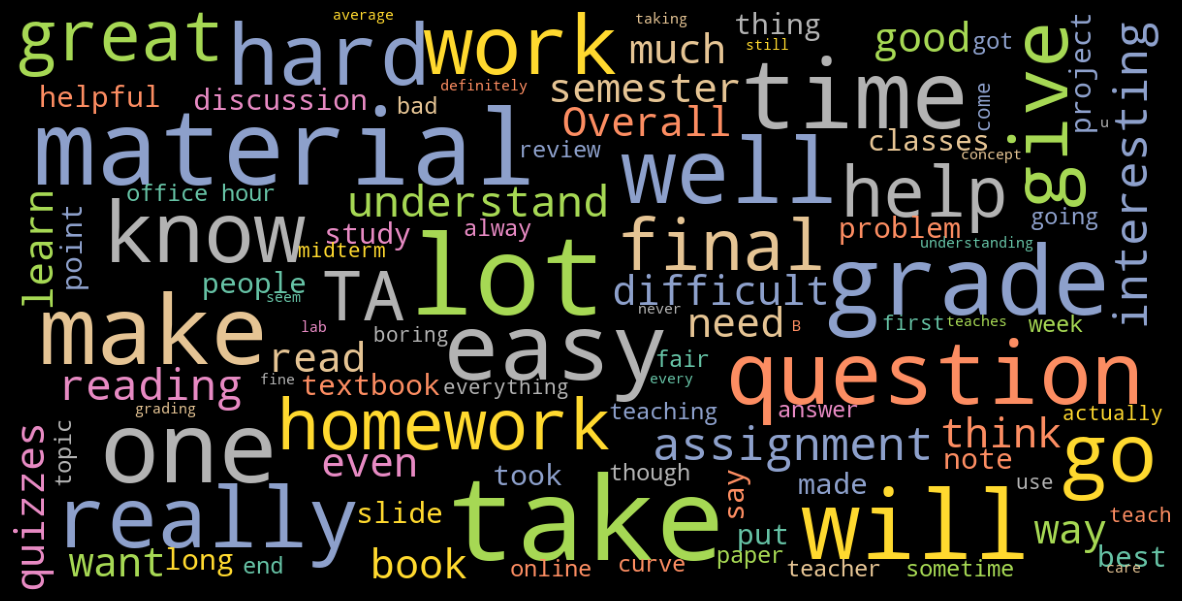

In [27]:
from wordcloud import WordCloud, STOPWORDS

wc = WordCloud(
    background_color="black",
    max_font_size=40,
    max_words=100,
    scale=3,
    colormap='Set2',
    stopwords=set(
        [
            "class",
            "course",
            "lecture",
            "professor",
            "student",
            "students",
            "exam",
            "exams",
            "test",
            "tests",
            "lectures",
        ]
    )
    | STOPWORDS,
).generate(merged_all_years_all_reviews["review"].str.cat(sep=" "))
plt.figure(figsize=(15, 10))
plt.imshow(wc)
plt.axis("off")
plt.show()


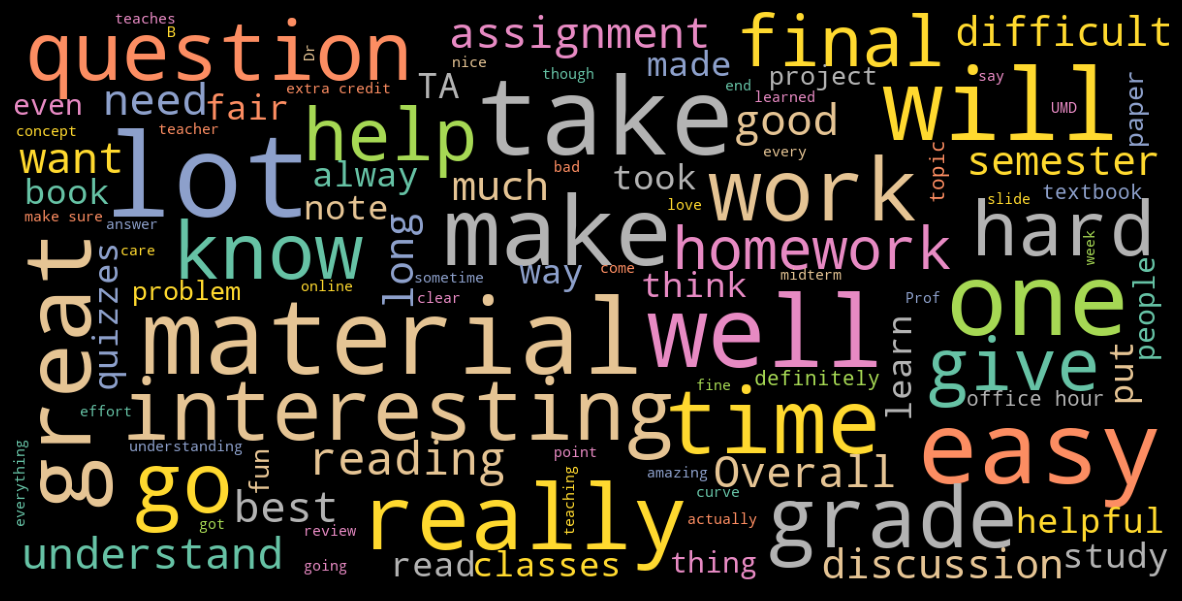

In [34]:
year_df[year_df["num_reviews"] >= 3]
wc = WordCloud(
    background_color="black",
    max_font_size=40,
    max_words=100,
    scale=3,
    colormap='Set2',
    stopwords=set(
        [
            "class",
            "course",
            "lecture",
            "professor",
            "student",
            "students",
            "exam",
            "exams",
            "test",
            "tests",
            "lectures",
        ]
    )
    | STOPWORDS,
).generate(merged_all_years_all_reviews[merged_all_years_all_reviews["rating"] > 3]["review"].str.cat(sep=" "))
plt.figure(figsize=(15, 10))
plt.imshow(wc)
plt.axis("off")
plt.show()


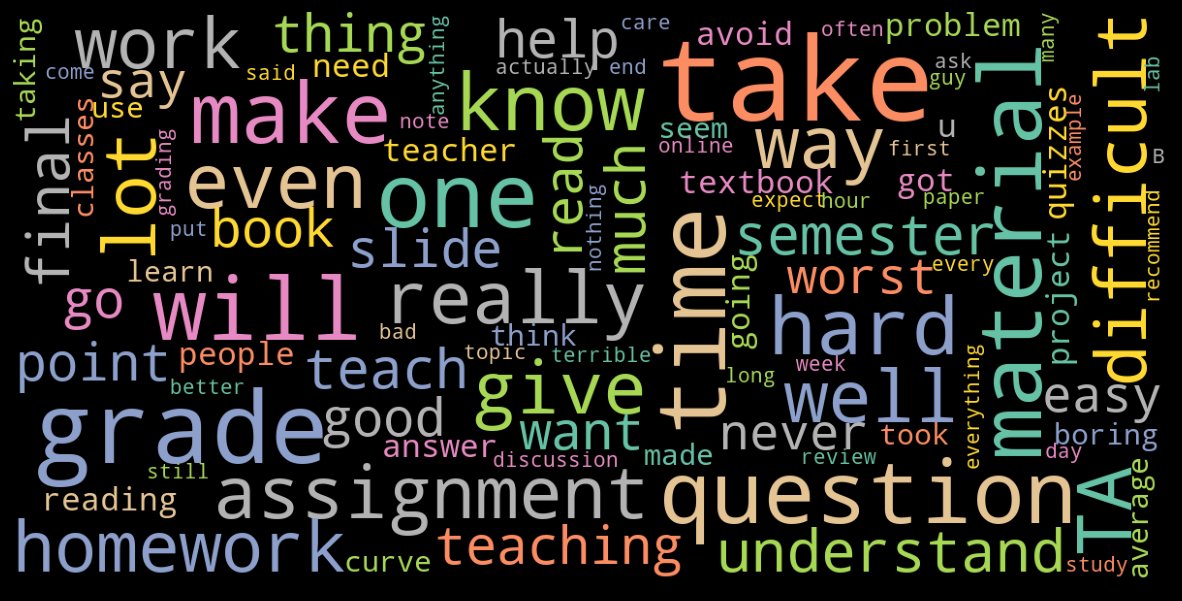

In [35]:
year_df[year_df["num_reviews"] >= 3]
wc = WordCloud(
    background_color="black",
    max_font_size=40,
    max_words=100,
    scale=3,
    colormap='Set2',
    stopwords=set(
        [
            "class",
            "course",
            "lecture",
            "professor",
            "student",
            "students",
            "exam",
            "exams",
            "test",
            "tests",
            "lectures",
        ]
    )
    | STOPWORDS,
).generate(merged_all_years_all_reviews[merged_all_years_all_reviews["rating"] < 3]["review"].str.cat(sep=" "))
plt.figure(figsize=(15, 10))
plt.imshow(wc)
plt.axis("off")
plt.show()